## Import Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import cm, pyplot as plt
%matplotlib inline

In [0]:
#!pip install --user git+https://github.com/hmmlearn/hmmlearn

  Cloning https://github.com/hmmlearn/hmmlearn to /tmp/pip-req-build-pnmnxv3o
  Running command git clone -q https://github.com/hmmlearn/hmmlearn /tmp/pip-req-build-pnmnxv3o
  Created wheel for hmmlearn: filename=hmmlearn-0.2.3.post2+g0e9274c-cp36-cp36m-linux_x86_64.whl size=325955 sha256=deff5301ca64082546a3d4c5601b3741feddf384271286c5cc0a1fb87cc53c96
  Stored in directory: /tmp/pip-ephem-wheel-cache-heac57hf/wheels/02/e9/26/ba89ec3c567c3583f0d34b8627dd594b651d41304a59eeb8f3
Successfully built hmmlearn


In [0]:
import hmmlearn
from hmmlearn import hmm

## Read Data

In [0]:
state_seq = []
observation_seq = []

f = open('weather-test1-1000.txt','r')
line = f.readline()
while line:
    line=line.rstrip().split(',')
    
    # encoding: sunny:0, rainy:1, foggy:2
    if line[0] == 'sunny':
        state_seq.append(0)
    elif line[0] == 'rainy':
        state_seq.append(1)
    else:
        state_seq.append(2)
    
    # encoding: yes:0, no:1
    if line[1] == 'yes':
        observation_seq.append(0)
    else:
        observation_seq.append(1)
    line = f.readline()

## Exploratory analysis

In [0]:
# hidden states map
z_decode = {0:'sunny',1:'rainy',2:'foggy'}
z_encode = {'sunny':0,'rainy':1,'foggy':2}

# possible observations
# 'yes' for unbrella is observed
x_decode = {0:'yes',1:'no'}
x_encode = {'yes':0,'no':1}

# start probability vector for hidden states 
# P(sunny) = 0.5, P(rainy) = 0.25, P(foggy) = 0.25
start_prob = [0.5, 0.25, 0.25]

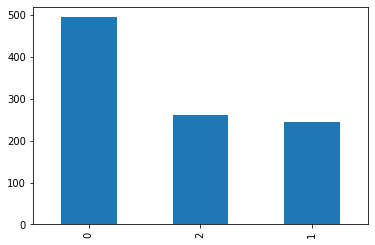

In [0]:
#distribution of states
pd.Series(state_seq).value_counts().plot(kind='bar')

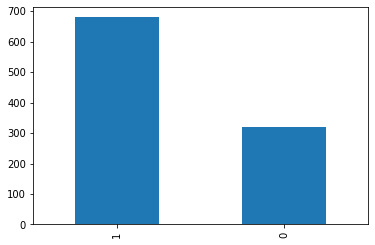

In [0]:
# distribution of observations
pd.Series(observation_seq).value_counts().plot(kind='bar')

In [0]:
df = pd.DataFrame({'hidden':state_seq,'observation':observation_seq})
df.groupby(['hidden','observation'])['observation'].count()

hidden  observation
0       0               42
        1              452
1       0              199
        1               46
2       0               79
        1              182
Name: observation, dtype: int64

Text(0, 0.5, 'Weather')

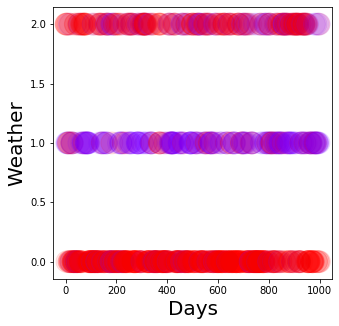

In [0]:
fig = plt.figure(figsize=(5,5)) 
fig1 = fig.add_subplot(111)
fig1.scatter(range(1,len(state_seq)+1), state_seq, s=480, c=observation_seq, alpha=0.1, cmap=plt.cm.rainbow)
fig1.set_xlabel('Days', fontsize=20)
fig1.set_ylabel('Weather', fontsize=20)

**Sunny:0, rainy:1, foggy:2**

**With umbrella: blue, without umbrella: red**

For sunny, we see most of the times there are no umbrella

For rainy, we see the majority of the time ther are umbrellas

For foggy, there are more days we see no umbrella than days we see there are.

### Compute hidden state transitional probability matrix

In [0]:
state_occurrence_dic = {}
for i in range(1,len(state_seq)):
    if state_seq[i-1] not in state_occurrence_dic:
        state_occurrence_dic[state_seq[i-1]] = {state_seq[i]:1}
    else:
        if state_seq[i] not in state_occurrence_dic[state_seq[i-1]]:
            state_occurrence_dic[state_seq[i-1]][state_seq[i]] = 1
        else:
            state_occurrence_dic[state_seq[i-1]][state_seq[i]] += 1

In [0]:
state_occurrence_dic

{0: {0: 392, 1: 27, 2: 74},
 1: {0: 48, 1: 142, 2: 55},
 2: {0: 54, 1: 76, 2: 131}}

In [0]:
sunny = np.array(list(state_occurrence_dic[0].values()))/float(sum(list(state_occurrence_dic[0].values())))
rainy = np.array(list(state_occurrence_dic[1].values()))/float(sum(list(state_occurrence_dic[1].values())))
foggy = np.array(list(state_occurrence_dic[2].values()))/float(sum(list(state_occurrence_dic[2].values())))
transition_matrix = np.vstack((sunny,rainy,foggy))
transition_matrix

array([[0.15010142, 0.79513185, 0.05476673],
       [0.19591837, 0.57959184, 0.2244898 ],
       [0.50191571, 0.29118774, 0.20689655]])

### Compute emission probability matrix¶

In [0]:
ob_occurrence_dic = {}
for i in range(len(state_seq)):
    if state_seq[i] not in ob_occurrence_dic:
        ob_occurrence_dic[state_seq[i]] = {observation_seq[i]:1}
    else:
        if observation_seq[i] not in ob_occurrence_dic[state_seq[i]]:
            ob_occurrence_dic[state_seq[i]][observation_seq[i]] = 1
        else:
            ob_occurrence_dic[state_seq[i]][observation_seq[i]] += 1

In [0]:
ob_occurrence_dic

{0: {0: 42, 1: 452}, 1: {0: 199, 1: 46}, 2: {0: 79, 1: 182}}

In [0]:
sunny = np.array(list(ob_occurrence_dic[0].values()))/float(sum(list(ob_occurrence_dic[0].values())))
rainy = np.array(list(ob_occurrence_dic[1].values()))/float(sum(list(ob_occurrence_dic[1].values())))
foggy = np.array(list(ob_occurrence_dic[2].values()))/float(sum(list(ob_occurrence_dic[2].values())))
emission_matrix = np.vstack((sunny,rainy,foggy))
emission_matrix

array([[0.91497976, 0.08502024],
       [0.8122449 , 0.1877551 ],
       [0.69731801, 0.30268199]])

## Construct the HMM by approximating with the observation sequence

In [0]:
# n_components=3 means three hidden states [0, 1, 2]
# n_iter = Maximum number of iterations to perform when fitting using Expectation Maximization
model= hmm.MultinomialHMM(n_components=3, n_iter=1000)

# since the EM algorithm is a gradient-based optimization method, it will generally get stuck 
#in local optima. You should in general try to run fit with various initializations and select 
# the highest scored model.
model.fit(np.array(observation_seq).reshape(-1,1))

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=3,
               n_iter=1000, params='ste',
               random_state=RandomState(MT19937) at 0x7F231F4AAA98,
               startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
               verbose=False)

In [0]:
# probability of the model
print('log probability under the model: ', model.score(np.array(observation_seq).reshape(-1, 1)))
print('probability under the model: ', np.exp(model.score(np.array(observation_seq).reshape(-1, 1))))

log probability under the model:  -586.9650803390274
probability under the model:  1.2142400094477451e-255


#### Compare matrices

In [0]:
print('true transition probability matrix')
print(transition_matrix,'\n')

print('fitted transition probability matrix')
print(model.transmat_)

true transition probability matrix
[[0.15010142 0.79513185 0.05476673]
 [0.19591837 0.57959184 0.2244898 ]
 [0.50191571 0.29118774 0.20689655]] 

fitted transition probability matrix
[[0.51694401 0.08866104 0.39439495]
 [0.1852753  0.63131822 0.18340647]
 [0.49789855 0.11822909 0.38387236]]


In [0]:
print('true emission_matrix:')
print(emission_matrix ,'\n')

print('estimated emission matrix:')
print(model.emissionprob_)

true emission_matrix:
[[0.91497976 0.08502024]
 [0.8122449  0.1877551 ]
 [0.69731801 0.30268199]] 

estimated emission matrix:
[[0.07144138 0.92855862]
 [0.9444101  0.0555899 ]
 [0.24577776 0.75422224]]


In [0]:
print('actual start probabilities for hidden statesobabilities')
print(start_prob, '\n')

print('fitted emission probabilities for hidden states')
print(model.startprob_)

actual start probabilities for hidden statesobabilities
[0.5, 0.25, 0.25] 

fitted emission probabilities for hidden states
[9.99804755e-01 1.12241696e-49 1.95244787e-04]


#### With the constructed HMM, find the most likely state sequence corresponding to new observation sequence given

In [0]:
test_observation = ['no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no']
test_observation_encode = [x_encode[i] for i in test_observation]
test_observation_encode = np.atleast_2d(test_observation_encode).T
test_observation_encode

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1]])

In [0]:
log_prob, pred_sequence = model.decode(test_observation_encode, algorithm="viterbi")
for i in zip(test_observation,map(lambda x:z_decode[x], pred_sequence)):
    print("Observation on Umbrella:", i[0], ", Predicted Weather:", i[1])

Observation on Umbrella: no , Predicted Weather: sunny
Observation on Umbrella: yes , Predicted Weather: rainy
Observation on Umbrella: yes , Predicted Weather: rainy
Observation on Umbrella: no , Predicted Weather: sunny
Observation on Umbrella: yes , Predicted Weather: foggy
Observation on Umbrella: no , Predicted Weather: sunny
Observation on Umbrella: no , Predicted Weather: sunny
Observation on Umbrella: yes , Predicted Weather: foggy
Observation on Umbrella: no , Predicted Weather: sunny
Observation on Umbrella: no , Predicted Weather: sunny


#### Generate sample sequences for hidden states and observations

In [0]:
sample_observation, sample_hidden = model.sample(10)

# decode sample observation into yes/no
sample_observation = sample_observation.reshape(10)
sample_observation = map(lambda i: x_decode[i], sample_observation)

# decode sample weather into sunny/rainy/foggy
sample_hidden = map(lambda i : z_decode[i], sample_hidden)

for i in zip(sample_observation, sample_hidden):
    print("Observation on Umbrella:", i[0], ", Weather:", i[1])

Observation on Umbrella: no , Weather: sunny
Observation on Umbrella: no , Weather: foggy
Observation on Umbrella: no , Weather: sunny
Observation on Umbrella: no , Weather: foggy
Observation on Umbrella: no , Weather: foggy
Observation on Umbrella: no , Weather: sunny
Observation on Umbrella: no , Weather: foggy
Observation on Umbrella: yes , Weather: sunny
Observation on Umbrella: no , Weather: sunny
Observation on Umbrella: yes , Weather: foggy
